In [28]:
import json
import requests
import os
from rio_tiler.io import COGReader
import matplotlib.pyplot as plt

from rio_tiler.profiles import img_profiles
from rio_tiler.models import ImageData, Metadata
import folium 

In [29]:
# cog_path is a url that points to a cloud optimised GeoTiff
# local for development but will be deployed as an Azure blob
cwd = str(os.getcwd())
cog_path = 'file://' + cwd +'/cog/mc_1000_byte_cog.tif'

In [30]:
# titiler endpoint points to an instance of Titiler which dynamically generates web map tiles
# titiler will generate web map tiles that match a users extent and zoom level on web map
titiler_endpoint = "http://127.0.0.1:8000"
url = cog_path

In [31]:
# this is a demo web app logic 
# request web map tiles to be generated by Titiler from COG
r = requests.get(
    f"{titiler_endpoint}/tilejson.json",
    params = {
        "url": url,
        "colormap_name": "greens"
    }
).json()

# create a Leaflet web map (this will be what the user sees in their web browser)
m = folium.Map(
    location=(-5, 122),
    zoom_start=5
)

# create TileLayer to add to map
forest_layer = folium.raster_layers.TileLayer(
    tiles=r["tiles"][0],
    opacity=1,
    attr="test"
)
forest_layer.add_to(m)
m

In [5]:
# this is an dummy geoJSON file of coordinates supplied by a user where deforestation occurs
geojson = {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              114.08203125,
              -4.12728532324537
            ],
            [
              116.60888671874999,
              -4.12728532324537
            ],
            [
              116.60888671874999,
              -1.252341676699629
            ],
            [
              114.08203125,
              -1.252341676699629
            ],
            [
              114.08203125,
              -4.12728532324537
            ]
          ]
        ]
      }
    }


In [32]:
# display the geoJSON - this is what the user has drawm or uploaded
folium.GeoJson(geojson, name="geojson").add_to(m)
m

In [17]:
# read data from a tif file in a cloud bucket and clipped to GeoJson feature extent
with COGReader(cog_path) as cog:
    # we use the feature to define the bounds and the mask
    # but we use `dst_crs` options to keep the projection from the input dataset
    img = cog.feature(geojson, dst_crs=cog.dataset.crs)
    # this gets the data as a numpy array 
    img = img.data_as_image()

In [24]:
# do some numpy here to simulate deforestation driven temperature change
# output numpy array of predicted temperature change
img1 = img + 30

(262, 230, 1)


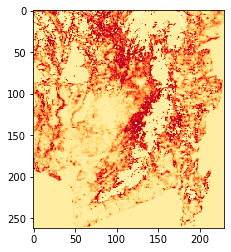

In [33]:
# create a temporary COG on Azure (on end of user session a clean up script will delete all Azure blobs)
# add temporary COG on users web map
# this a placeholder for creating a new web map to visualise temperature change
plt.imshow(img1, cmap='YlOrRd')